# NYC Real Data # 2
In response to a reviewer, we are testing each inflation method on COVID data in all of NYC and comparing the fits of the estimated parameters derived from different methods.




In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
from tqdm import tqdm
import syslog

## Pull Data

Pull:
- daily case data from NYC Health https://github.com/nychealth/coronavirus-data
- ascertainment rates from Nature Paper https://github.com/SenPei-CU/COVID_US_2020/tree/main
Pei, S., Yamana, T., Kandula, S., Galanti, M., Shaman, J. Burden and characteristics of COVID-19 in the United States during 2020. Nature 598, 338-341 (2021).


In [2]:
case_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/refs/heads/master/trends/cases-by-day.csv"
ascertainment_url = "https://raw.githubusercontent.com/SenPei-CU/COVID_US_2020/refs/heads/main/Output/AscertainmentRate.csv"

START_DATE = "2020-03-06"
END_DATE = "2021-07-01"

BX_FIPS = 36005
BK_FIPS = 36047
MN_FIPS = 36061
QN_FIPS = 36081
SI_FIPS = 36085

alpha_df = pd.read_csv(ascertainment_url)
alpha_df.head()

,County,FIPS,Month,2.5prctile,25prctile,50prctile,75prctile,97.5prctile
0,Autauga County AL,1001,3,NaN,NaN,NaN,NaN,NaN
1,Autauga County AL,1001,4,0.0658,0.1076,0.1475,0.2097,0.5396
2,Autauga County AL,1001,5,0.0935,0.1275,0.1520,0.1864,0.3154
3,Autauga County AL,1001,6,0.1106,0.1429,0.1656,0.1946,0.2848
4,Autauga County AL,1001,7,0.1164,0.1497,0.1727,0.2018,0.2968


Text(0.5, 1.0, 'Ascertainment rate by borough')

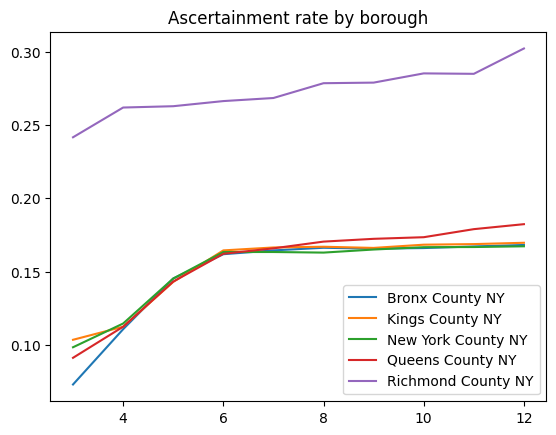

In [3]:
fig, ax = plt.subplots()

for fip in [BX_FIPS, BK_FIPS, MN_FIPS, QN_FIPS, SI_FIPS]:
    filtered_df = alpha_df.loc[alpha_df['FIPS'] == fip]
    county = filtered_df["County"].iloc[0]
    ax.plot(filtered_df["Month"], filtered_df["50prctile"], label=county)

ax.legend()
ax.set_title("Ascertainment rate by borough")

In [4]:
case_df = pd.read_csv(case_url)
case_df["date_of_interest"] = pd.to_datetime(case_df["date_of_interest"])
case_df.head()

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,BX_CASE_COUNT,BX_PROBABLE_CASE_COUNT,BX_CASE_COUNT_7DAY_AVG,BX_ALL_CASE_COUNT_7DAY_AVG,BK_CASE_COUNT,...,MN_ALL_CASE_COUNT_7DAY_AVG,QN_CASE_COUNT,QN_PROBABLE_CASE_COUNT,QN_CASE_COUNT_7DAY_AVG,QN_ALL_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,INCOMPLETE
0,2020-02-29,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2020-03-04,5,0,0,0,0,0,0,0,1,...,0,2,0,0,0,0,0,0,0,0


<Axes: xlabel='date_of_interest'>

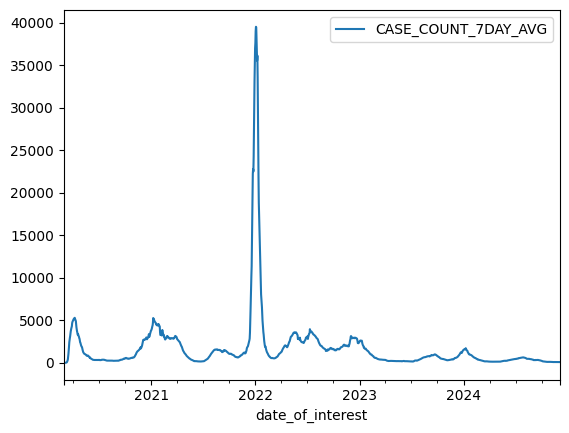

In [5]:
case_df[['date_of_interest', 'CASE_COUNT_7DAY_AVG']].plot(x='date_of_interest')

### Scale cases using ascertainment rates

In [6]:
alpha_wide_df = alpha_df.loc[alpha_df['FIPS'].isin([BX_FIPS, BK_FIPS, MN_FIPS, QN_FIPS, SI_FIPS])].pivot(index='Month', columns='FIPS', values='50prctile').reset_index()
alpha_wide_df = alpha_wide_df.rename(columns={col: f'alpha_{col}' for col in alpha_wide_df.columns if col not in ['Month', 'FIPS']})
alpha_wide_df['Year'] = 2020

# Merge the dataframes on Year and Month
case_df['Month'] = case_df['date_of_interest'].dt.month
case_df['Year'] = case_df['date_of_interest'].dt.year
cols = ['date_of_interest', 'BX_CASE_COUNT', 'BK_CASE_COUNT', 'MN_CASE_COUNT', 'QN_CASE_COUNT', 'SI_CASE_COUNT', 'Month', 'Year']

merged_df = pd.merge(case_df.loc[case_df['date_of_interest'] < END_DATE, cols], alpha_wide_df, on=["Year", "Month"], how='left')

merged_df = merged_df.ffill()
merged_df = merged_df.bfill()

# BX_FIPS = 36005
# BK_FIPS = 36047
# MN_FIPS = 36061
# QN_FIPS = 36081
# SI_FIPS = 36085
merged_df['BX_CASE_COUNT'] = merged_df['BX_CASE_COUNT'] / merged_df['alpha_36005']
merged_df['BK_CASE_COUNT'] = merged_df['BK_CASE_COUNT'] / merged_df['alpha_36047']
merged_df['MN_CASE_COUNT'] = merged_df['MN_CASE_COUNT'] / merged_df['alpha_36061']
merged_df['QN_CASE_COUNT'] = merged_df['QN_CASE_COUNT'] / merged_df['alpha_36081']
merged_df['SI_CASE_COUNT'] = merged_df['SI_CASE_COUNT'] / merged_df['alpha_36085']

merged_df["CASE_COUNT"] = merged_df[['BX_CASE_COUNT', 'BK_CASE_COUNT', 'MN_CASE_COUNT', 'QN_CASE_COUNT', 'SI_CASE_COUNT']].sum(axis=1)
merged_df["CASE_COUNT_7DAY_AVG"] = merged_df["CASE_COUNT"].rolling(window=7).mean()
merged_df.head()

,date_of_interest,BX_CASE_COUNT,BK_CASE_COUNT,MN_CASE_COUNT,QN_CASE_COUNT,SI_CASE_COUNT,Month,Year,alpha_36005,alpha_36047,alpha_36061,alpha_36081,alpha_36085,CASE_COUNT,CASE_COUNT_7DAY_AVG
0,2020-02-29,0.0,0.00000,10.17294,0.000000,0.0,2,2020,0.0729,0.1034,0.0983,0.0911,0.2416,10.172940,NaN
1,2020-03-01,0.0,0.00000,0.00000,0.000000,0.0,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,0.000000,NaN
2,2020-03-02,0.0,0.00000,0.00000,0.000000,0.0,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,0.000000,NaN
3,2020-03-03,0.0,0.00000,0.00000,10.976948,0.0,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,10.976948,NaN
4,2020-03-04,0.0,9.67118,20.34588,21.953897,0.0,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,51.970957,NaN


<Axes: xlabel='date_of_interest'>

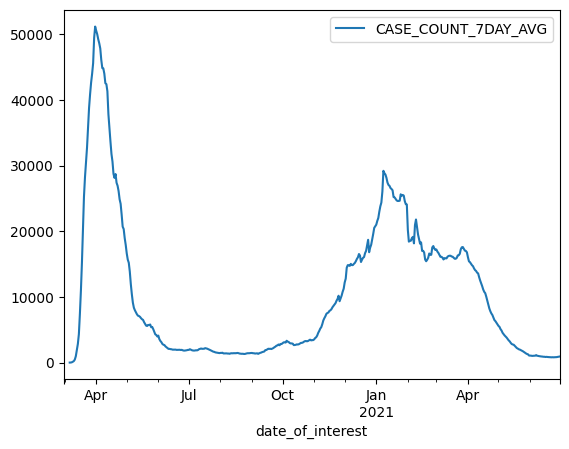

In [7]:
merged_df.plot(x='date_of_interest', y='CASE_COUNT_7DAY_AVG')

## Run EAKF

### Initial conditions

- $I_0$
    - "Specifically, we randomly drew E and Iu from uniform distributions [0, 12C] and [0, 10C] 9 days before the first date with more than five reported cases, T_0, where C is the total number of reported cases between day T_0, and T_0+ 4."

In [8]:
merged_df.loc[merged_df["CASE_COUNT"] > 5]

,date_of_interest,BX_CASE_COUNT,BK_CASE_COUNT,MN_CASE_COUNT,QN_CASE_COUNT,SI_CASE_COUNT,Month,Year,alpha_36005,alpha_36047,alpha_36061,alpha_36081,alpha_36085,CASE_COUNT,CASE_COUNT_7DAY_AVG
0,2020-02-29,0.000000,0.000000,10.172940,0.000000,0.000000,2,2020,0.0729,0.1034,0.0983,0.0911,0.2416,10.172940,NaN
3,2020-03-03,0.000000,0.000000,0.000000,10.976948,0.000000,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,10.976948,NaN
4,2020-03-04,0.000000,9.671180,20.345880,21.953897,0.000000,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,51.970957,NaN
5,2020-03-05,0.000000,29.013540,0.000000,0.000000,0.000000,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,29.013540,NaN
6,2020-03-06,27.434842,9.671180,30.518820,10.976948,4.139073,3,2020,0.0729,0.1034,0.0983,0.0911,0.2416,82.740863,26.410750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2021-06-26,65.437240,218.160377,89.712919,170.049369,79.417604,6,2021,0.1681,0.1696,0.1672,0.1823,0.3022,622.777509,849.483705
484,2021-06-27,101.130280,165.094340,113.636364,126.165661,72.799471,6,2021,0.1681,0.1696,0.1672,0.1823,0.3022,578.826114,856.605599
485,2021-06-28,172.516359,288.915094,269.138756,290.729567,99.272005,6,2021,0.1681,0.1696,0.1672,0.1823,0.3022,1120.571782,887.216114
486,2021-06-29,190.362879,306.603774,251.196172,279.758640,115.817340,6,2021,0.1681,0.1696,0.1672,0.1823,0.3022,1143.738804,915.165076


In [9]:
T0 = pd.to_datetime("2020-03-03")
C = merged_df.loc[(merged_df["date_of_interest"] >= T0) & (merged_df["date_of_interest"] < T0 + pd.Timedelta(days=4)), "CASE_COUNT"].sum()
C

174.70230804870891

In [10]:
case_data = merged_df[(merged_df["date_of_interest"] >= START_DATE) & (merged_df["date_of_interest"] < END_DATE)]

In [11]:
from numpy.random import uniform
from epyfilter.eakf import model_da, eakf, enks
from epyfilter.simulate import simulate_data

# NYC population
N = 8.2*10**6

I0 = 5 * C
I0_lower = 0
I0_upper = 10 * C


true_params = {
    'rt_0': 1.3,
    'rt_1': 4.8, 
    'midpoint': 100,
    'k': 0.2,
    'n_t': case_data.shape[0],
    't_I': 3.50,
    'S0': N - I0,
    'I0': I0,
    'N': N,
}

np.random.seed(1994)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)
real_cases = case_data['CASE_COUNT_7DAY_AVG'].values
data.i_true = real_cases
data.i = real_cases


prior = {
            "beta": {
                "dist": uniform,
                "args": {
                    "low": 0.02,
                    "high": 0.3,
                },
            },
            "t_I": {
                "dist": "constant",
            }
        }

state_prior = {
    "I" : {
        "dist": uniform,
        "args": {
            "low": I0_lower / N,
            "high": I0_upper / N,
        }
    }
}

def oev(z):
    return np.maximum(10, z**2/50)


n_ens = 300
# model = model_da.SIR_model(data)
model = model_da.SIR_model(data, state_prior)
    

# adaptive
kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf.filter(prior, inf_method="adaptive")

# ensrs
ks = enks.EnsembleSquareRootSmoother(kf)
ks.smooth(window_size=10, plot=False)

# no inflation
kf_none = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf_none.oev = oev
kf_none.filter(prior, inf_method="none")

# fixed inflation
kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf_fixed.oev = oev
kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)


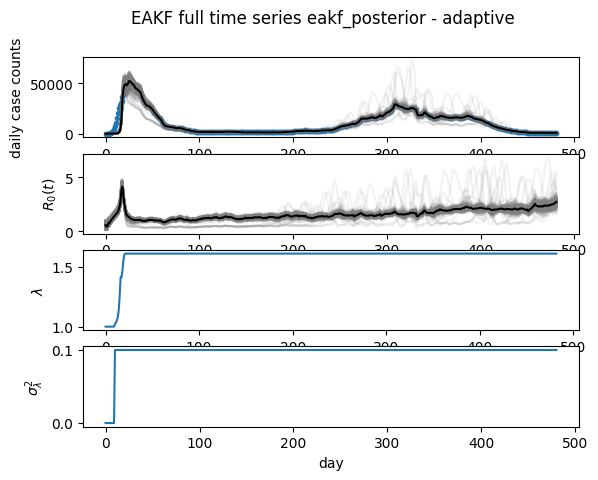

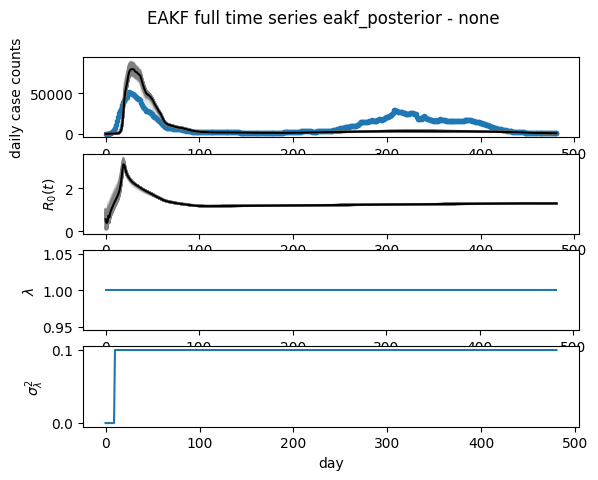

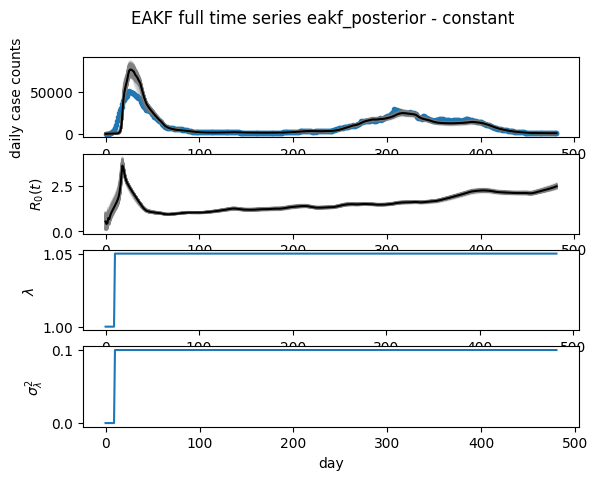

In [12]:
def plot_posterior(kf, title):
    fig, ax = plt.subplots(4)
    
    ax[0].plot(kf.data.i, '.')
    ax[0].plot([x.i for x in kf.x_list], color='gray', alpha=0.1)
    ax[0].plot(np.mean([x.i for x in kf.x_list], axis=1), color='black')
    ax[0].set_ylabel('daily case counts')

    ax[1].plot([θ.beta * θ.t_I for θ in kf.θ_list], color="gray", alpha=0.1)
    ax[1].plot(
        np.mean([θ.beta * θ.t_I for θ in kf.θ_list], axis=1), color="black")
    ax[1].set_xlabel('day')
    ax[1].set_ylabel(r'$R_0(t)$')

    ax[2].plot(np.linspace(0, kf.data.n_t, kf.data.n_t-1),
                np.append(np.ones(kf.data.n_t - len(kf.lam_list) - 1),
                            kf.lam_list))
    ax[2].set_xlabel("day")
    ax[2].set_ylabel(r"$\lambda$")

    ax[3].plot(np.concatenate(
        (np.zeros(kf.data.n_t - len(kf.lam_var_list)-1),
            kf.lam_var_list)))
    ax[3].set_xlabel("day")
    ax[3].set_ylabel(r"$\sigma^2_{\lambda}$")

    fig.suptitle(f'EAKF full time series eakf_posterior - {title}')

plot_posterior(kf, f"adaptive")
plot_posterior(kf_none, f"none")
plot_posterior(kf_fixed, f"constant")

/tmp/11770167.1.std_12h.q/ipykernel_58119/384953797.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


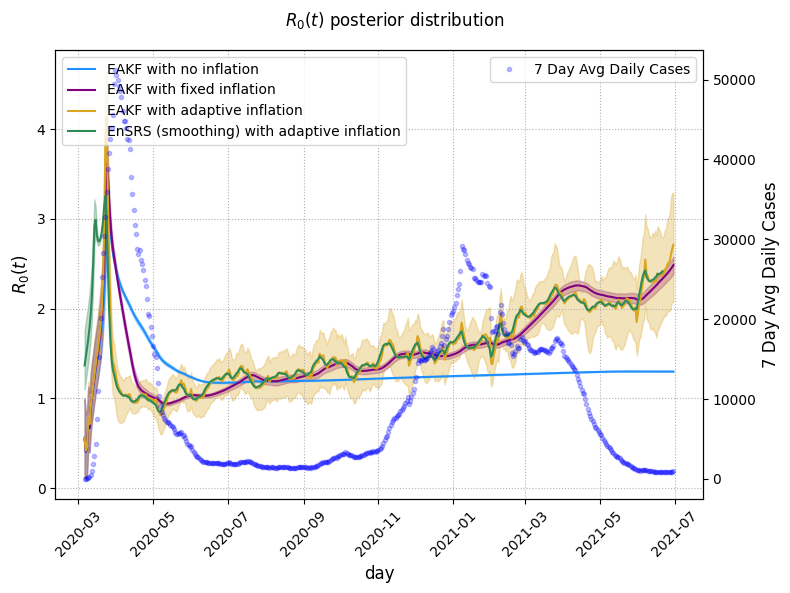

In [13]:
def compute_ci_mean(kf, smooth=False, confidence_level=95):
    if smooth:
         array = np.array([θ.beta*θ.t_I for θ in kf.θ_lag_list])
    else:
        array = np.array([θ.beta * θ.t_I for θ in kf.θ_list])
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean


# compute mean and cis
ci_no, mean_no = compute_ci_mean(kf_none)
ci_fixed, mean_fixed = compute_ci_mean(kf_fixed)
ci_adapt, mean_adapt = compute_ci_mean(kf)
ci_smooth, mean_smooth = compute_ci_mean(ks, smooth=True)

fig, ax = plt.subplots()
fig.suptitle(r"$R_0(t)$ posterior distribution")
fig.set_figheight(6)
fig.set_figwidth(8)

dates = case_data["date_of_interest"]

ax.fill_between(dates, ci_no[0,:], ci_no[1,:], color='dodgerblue', alpha=0.3)
ax.plot(dates, mean_no, color="dodgerblue", label=r"EAKF with no inflation")

ax.fill_between(dates, ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
ax.plot(dates, mean_fixed, color="purple", label=r"EAKF with fixed inflation")

ax.fill_between(dates, ci_adapt[0,:], ci_adapt[1,:], color='goldenrod', alpha=0.3)
ax.plot(dates, mean_adapt, color="goldenrod", label=r"EAKF with adaptive inflation")

ax.fill_between(dates[:-9], ci_smooth[0,:], ci_smooth[1,:], color='seagreen', alpha=0.3)
ax.plot(dates[:-9], mean_smooth, color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")

# plot cases in background
ax2 = ax.twinx()
ax2.plot(dates, case_data['CASE_COUNT_7DAY_AVG'], '.', alpha=0.25, color='blue', label='7 Day Avg Daily Cases')
ax2.set_ylabel('7 Day Avg Daily Cases', fontsize=12)
ax2.legend(loc='upper right')

ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"$R_0(t)$", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.legend(loc='upper left')
ax.grid(linestyle='dotted')
fig.tight_layout()
# fig.savefig('real_data_eakf_posterior.png')
# fig.savefig(f"real_data_eakf_posterior.eps", format='eps', bbox_inches='tight', transparent=True)
# fig.savefig(f"real_data_eakf_posterior.pdf", bbox_inches='tight', transparent=True)

In [14]:
mean_smooth[20]

1.994699567408182

In [15]:
mean_adapt[20]

2.565001744213643

In [16]:
# compute ppd
kf.free_sim(np.asarray([θ.beta for θ in kf.θ_list]), add_noise=True)
ks.free_sim(np.asarray([θ.beta for θ in ks.θ_lag_list]), add_noise=True)
kf_none.free_sim(np.asarray([θ.beta for θ in kf_none.θ_list]), add_noise=True)
kf_fixed.free_sim(np.asarray([θ.beta for θ in kf_fixed.θ_list]), add_noise=True)

# compute reliabilty
percentiles = np.arange(2.5, 100, 2.5)

kf.compute_reliability(percentiles)
ks.compute_reliability(percentiles)
kf_none.compute_reliability(percentiles)
kf_fixed.compute_reliability(percentiles)

/tmp/11770167.1.std_12h.q/ipykernel_58119/2193733460.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/11770167.1.std_12h.q/ipykernel_58119/2193733460.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/11770167.1.std_12h.q/ipykernel_58119/2193733460.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/11770167.1.std_12h.q/ipykernel_58119/2193733460.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


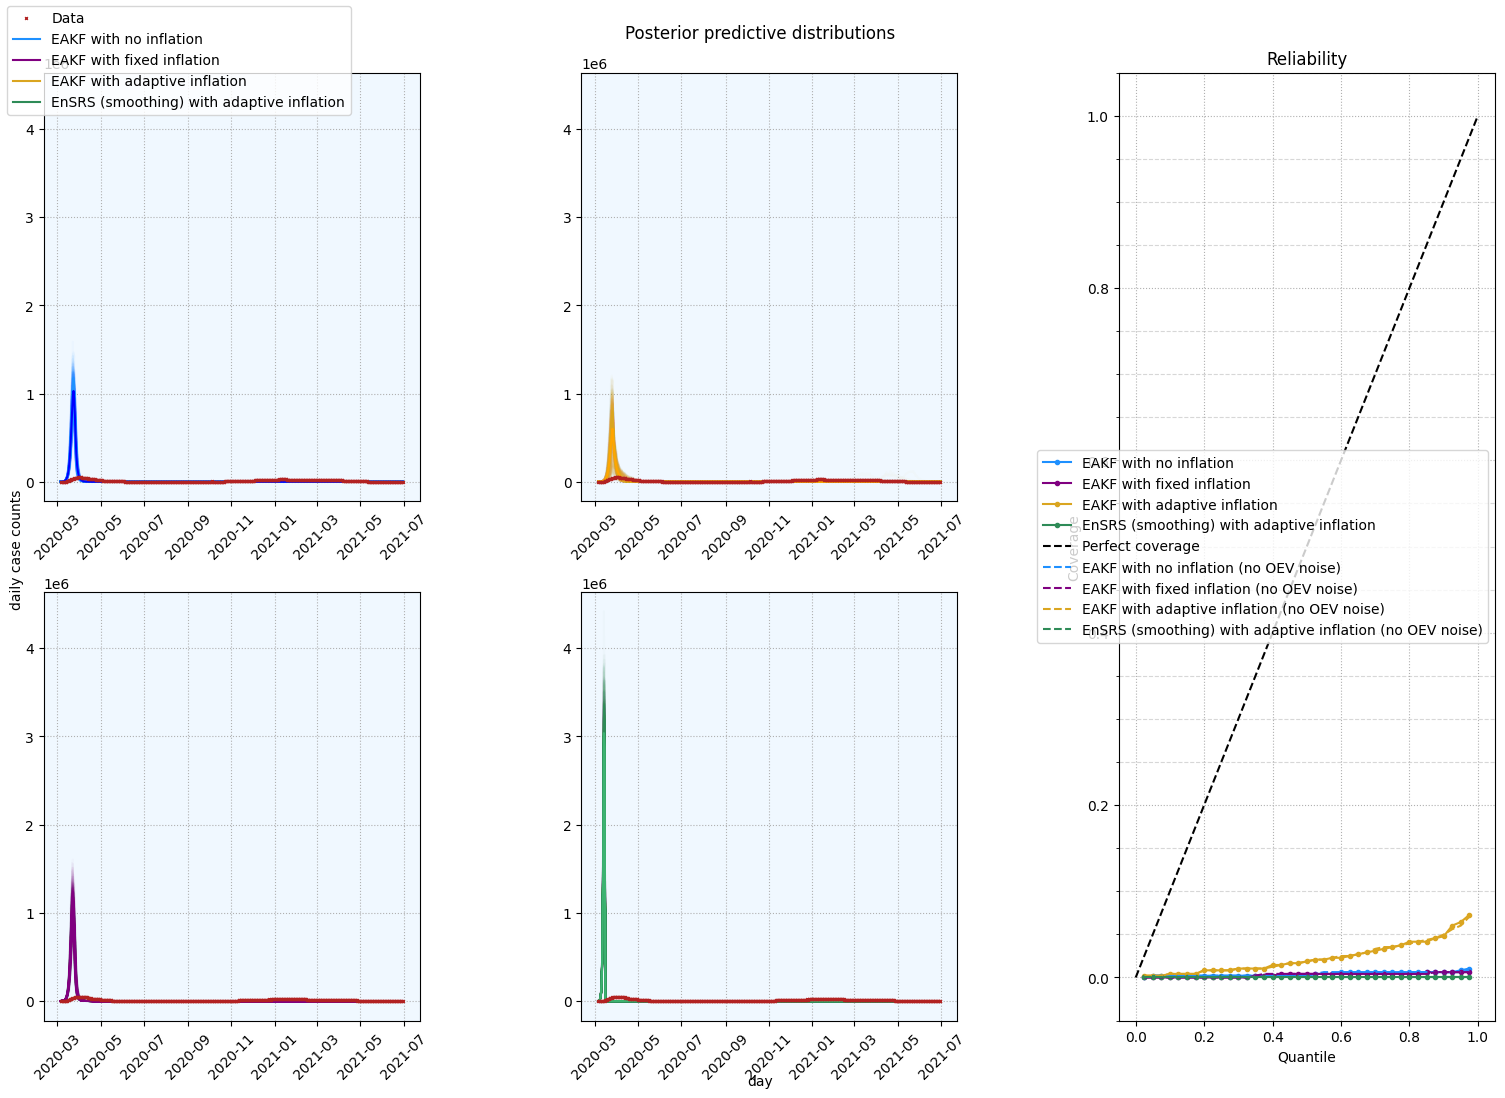

In [17]:
# plot ppd
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

dates = case_data["date_of_interest"]
truth = data.i

fig = plt.figure(figsize=(7.5*2, 8.75*1.25))

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

# no inflation
ax1 = plt.subplot(gs[0,0])
ax1.plot(dates, kf_none.i_ppc[1:], color="dodgerblue", alpha=0.02)
ax1.plot(dates, np.mean(kf_none.i_ppc[1:], axis=1), color='blue')
ax1.plot(dates, truth, "x", color='firebrick', markersize=2)

# fixed inflation
ax2 = plt.subplot(gs[1,0], sharey=ax1)
ax2.plot(dates, kf_fixed.i_ppc[1:], color="purple", alpha=0.02)
ax2.plot(dates, np.mean(kf_fixed.i_ppc[1:], axis=1), color='purple')
ax2.plot(dates, truth, "x", color='firebrick', markersize=2)

# adaptive inflation
ax3 = plt.subplot(gs[0,1], sharey=ax1)
ax3.plot(dates, kf.i_ppc[1:], color="goldenrod", alpha=0.02)
ax3.plot(dates, np.mean(kf.i_ppc[1:], axis=1), color='orange')
ax3.plot(dates, truth, "x", color='firebrick', markersize=2)

# ensrs
ax4 = plt.subplot(gs[1,1], sharey=ax1)
ax4.plot(dates[:-9], ks.i_ppc[1:], color="seagreen", alpha=0.02)
ax4.plot(dates[:-9], np.mean(ks.i_ppc[1:], axis=1), color='mediumseagreen')
ax4.plot(dates, truth, "x", color='firebrick', markersize=2)

# reliability
ax5 = plt.subplot(gs[:,2])
ax5.plot(percentiles / 100, kf_none.prop_list, ".-", label = 'EAKF with no inflation', color='dodgerblue')
ax5.plot(percentiles / 100, kf_fixed.prop_list, ".-", label='EAKF with fixed inflation', color='purple')
ax5.plot(percentiles / 100, kf.prop_list, ".-", label='EAKF with adaptive inflation', color='goldenrod')
ax5.plot(percentiles / 100, ks.prop_list, ".-", label='EnSRS (smoothing) with adaptive inflation', color='seagreen')
ax5.plot([0, 1], [0, 1], '--', color="k", label="Perfect coverage")

# # reliability no noise

def compute_reliability(kk, percentiles):
    prop_list = []
    for p in percentiles:
        lower = np.quantile(
            kk.i_ppc_true, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0, :]
        upper = np.quantile(
            kk.i_ppc_true, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1, :]
        
        if len(kk.i_ppc) < len(kk.data.i) + 1:
            pp = (lower <= kk.data.i[:len(kk.i_ppc)]) & (kk.data.i[:len(kk.i_ppc)] <= upper)
            prop_list.append(np.mean(pp[np.where(kk.data.i[:len(kk.i_ppc)] > 5)]))
        else:
            pp = (lower[1:] <= kk.data.i) & (kk.data.i <= upper[1:])
            prop_list.append(np.mean(pp[np.where(kk.data.i > 5)]))
    return prop_list

ax5.plot(percentiles / 100, compute_reliability(kf_none, percentiles), "--", label = 'EAKF with no inflation (no OEV noise)', color='dodgerblue')
ax5.plot(percentiles / 100, compute_reliability(kf_fixed, percentiles), "--", label='EAKF with fixed inflation (no OEV noise)', color='purple')
ax5.plot(percentiles / 100, compute_reliability(kf, percentiles), "--", label='EAKF with adaptive inflation (no OEV noise)', color='goldenrod')
ax5.plot(percentiles / 100, compute_reliability(ks, percentiles), "--", label='EnSRS (smoothing) with adaptive inflation (no OEV noise)', color='seagreen')

ax5.set_title("Reliability")
ax5.set_ylabel("Coverage")
ax5.set_xlabel("Quantile")
ax5.legend()

ax5.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax5.grid(which='minor', linestyle='--', alpha=0.5)
ax5.grid(linestyle='dotted')


ax1.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')
ax4.grid(linestyle='dotted')


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_facecolor('aliceblue')

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
fig.text(0, 0.5, 'daily case counts', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'day', ha='center')
fig.suptitle('Posterior predictive distributions', fontsize=12)

# add legend
red_line = mlines.Line2D([], [], color='firebrick', marker='x', linestyle='None', markersize=2) 
blue_line = mlines.Line2D([], [], color='dodgerblue', linestyle='-')
purple_line = mlines.Line2D([], [], color='purple', linestyle='-')
orange_line = mlines.Line2D([], [], color='goldenrod', linestyle='-')
green_line = mlines.Line2D([], [], color='seagreen', linestyle='-')

handles = [red_line, blue_line, purple_line, orange_line, green_line]
labels = ['Data', 'EAKF with no inflation', 'EAKF with fixed inflation', 'EAKF with adaptive inflation', 'EnSRS (smoothing) with adaptive inflation']
fig.legend(handles, labels, loc='upper left')

plt.tight_layout()
# fig.savefig('real_data_eakf_ppd.png')
# fig.savefig(f"real_data_eakf_ppd.eps", format='eps', bbox_inches='tight', transparent=True)
# fig.savefig(f"real_data_eakf_ppd.pdf", bbox_inches='tight', transparent=True)

In [18]:
data.S0

8199126

In [20]:
data.N - data.S0

873

In [21]:
data.I0

873